# Time Series - Historical data on taxi orders at airports

# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

In [1]:
#!pip install pmdarima

In [2]:
#pip install --upgrade patsy

In [3]:
#pip install statsmodels

In [4]:
from sklearn.model_selection import train_test_split
import numpy as np, pandas as pd
from math import sqrt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error

from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import adfuller
from numpy import log

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, cross_validate


import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
df = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=[0])
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [6]:
# Sort values chronologically
df.sort_index(inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


The data contains information for a period of six months between the dates March 2018 to August 2018.

In [8]:
# Check duplicates
df.index.duplicated().sum()

0

In [9]:
# Resmaple the intervals to 1H and sum up the values in the group 
df = df.resample('1H').sum()

In [10]:
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


The data is ready for analysis because the time interval is an hour, there are no duplicate values, and there are no missing values. In most valus, the average travels per hour is between 50 and 100 orders per hour and now is the time to check how the data is distributed over time, and what is its trend.

## Analysis

### General analysis

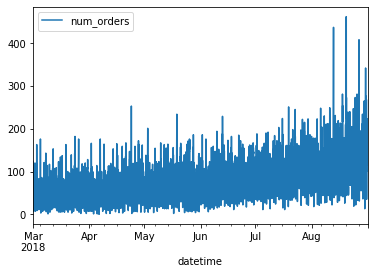

In [11]:
# General distibution of orders over time
df.plot();

The data looks generally stationary with a slight upward trend towards summer

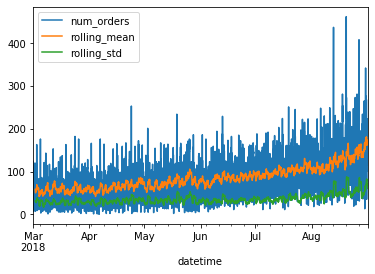

In [12]:
# Check the rolling mean
df1 = df.copy()
df1['rolling_mean'] = df1.num_orders.rolling(30).mean()
df1['rolling_std'] = df1.num_orders.rolling(30).std()
df1.plot();

The rolling mean (the greater its value) shows the trend of the data, it can be seen that it is relatively constant over time with a slight increase towards the summer. This means that the average does change over time and therefore the data is not so stationary

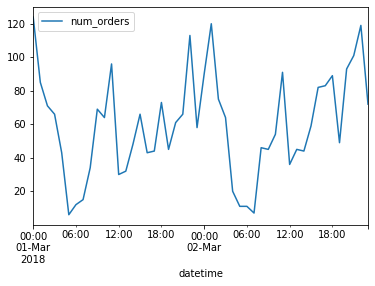

In [13]:
# Check the seasonality for two days
df['2018-03-01':'2018-03-02'].plot();

There is a certain recurrence of the total orders for the day and night. When during the day there is an increase in the number of orders and during the night there is a drop in the number of orders.

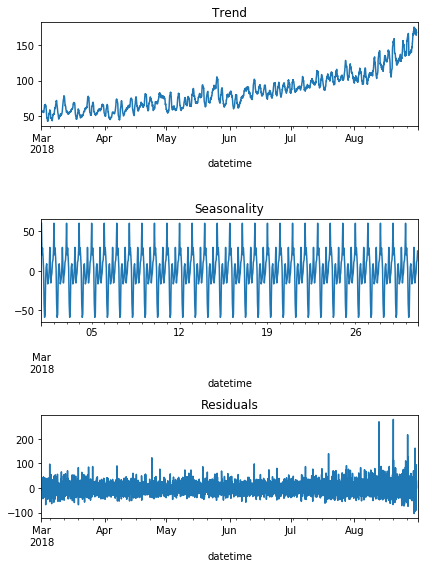

In [14]:
# Trend and Seasonality
decompose = seasonal_decompose(df)

plt.figure(figsize=(6, 8))

# Graph fot trend
plt.subplot(311) # Arranging the graph in spatial
decompose.trend.plot(ax = plt.gca()) #
plt.title('Trend')

# Graph for seasonality
plt.subplot(312)
decompose.seasonal[0:720].plot(ax = plt.gca())
plt.title('Seasonality')

# Graph for residual 
plt.subplot(313)
decompose.resid.plot(ax = plt.gca())
plt.title('Residuals')

plt.tight_layout()

Using seasonal_decompose it can be see the trend, the seasonality and the residuals. As we have already written, there is indeed a slight upward trend towards the summer in the total orders but in general the total orders are quite constant over time. In terms of seasonality, there is a recurrence in the total orders, and from a monthly check (24 * 30) as shown in the graph, a significant recurrence can be seen. The residuals are basically the differences between the original values and trend and seasonality.

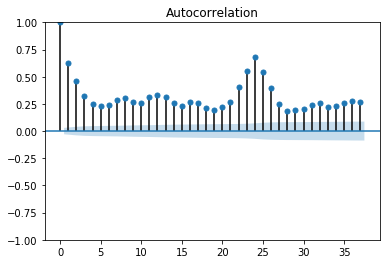

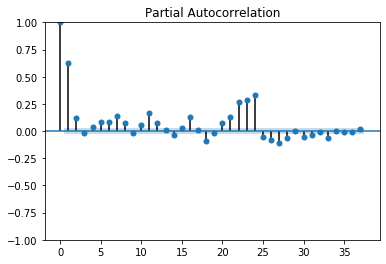

In [15]:
plot_acf(df);
plot_pacf(df);

According to the graphs it is not possible to unambiguously determine the type of data (stationary) since sometimes there is a gradual decrease and sometimes there are sharp changes. It is therefore necessary to test this using the ADF test

### Check the stationary 

A stationary process is a stochastic process in which the density of the joint split does not change with time shift. We will check if the data is stationary using the Augmented Dickey Fuller test. In this test we can define the null hypothesis where a time series is not stationary so if p-value is less than the significant level we can reject a null hypothesis and say that the data is stationary.

alpha = 0.05

* H0: the data is non-stationary
* H1: the data is stationary

In [16]:
result = adfuller(df.num_orders)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -3.068924
p-value: 0.028940


According to the result obtained, the null hypothesis can be rejected, the data is considered stationary even though the negative value of ADF is relatively low and indicates that the data is not stationary at 100%. We will examine the ADF around a deterministic trend (the range of the test set where the increase begins) and see if the data is stationary even then.

In [17]:
result = adfuller(df.num_orders[3000:])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.783860
p-value: 0.388504


Here it can already be seen that the data is non-stationary and this means that the data should be treated as non-stationary in the construction of the model

## Trainig

### Dummy model

In [18]:
# Create training and test sets without shuffle in order to maintain the order of the data
train, test = train_test_split(df, shuffle=False, test_size=0.1) 

In [19]:
# All the values in test set predict as constant number
pred_mdeian = np.ones(test.shape) * train.num_orders.median()
rmse_dm = sqrt(mean_squared_error(test.num_orders, pred_mdeian))
print('RMSE for dummy model with constant =', rmse_dm)

RMSE for dummy model with constant = 87.15277582981295


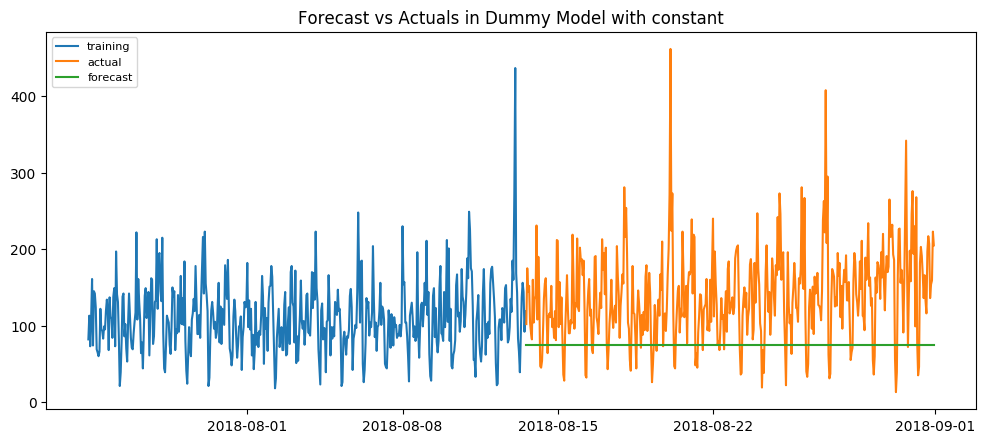

In [20]:
my_list = map(lambda x: x[0], pred_mdeian)
fc_series = pd.Series(my_list, index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train[3500:], label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.title('Forecast vs Actuals in Dummy Model with constant')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [21]:
pred_previous = test.shift()
pred_previous.iloc[0] = train.iloc[-1]
rmse_dm = sqrt(mean_squared_error(test.num_orders, pred_previous))
print('RMSE for dummy model with prediction previous value =', rmse_dm)

RMSE for dummy model with prediction previous value = 58.856486242815066


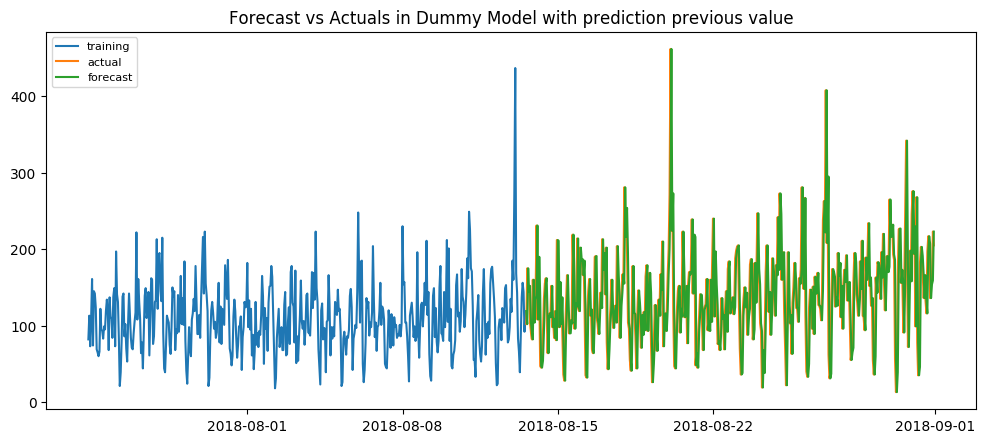

In [22]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train[3500:], label='training')
plt.plot(test, label='actual')
plt.plot(pred_previous, label='forecast')
plt.title('Forecast vs Actuals in Dummy Model with prediction previous value')
plt.legend(loc='upper left', fontsize=8)
plt.show()

### ARIMA

In [23]:
# Check the values of hyperparameters for tuning ARIMA model using auto arima
train_1 = train.copy()
train_1 = train_1.astype('uint8')
train_1 = train_1[:1000]
stepwis_fit = auto_arima(train_1, trace=True, seasonality=True, suppress_warning=True, m=24)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[24] intercept   : AIC=8698.474, Time=104.21 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=9597.990, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=8998.184, Time=31.99 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=9209.755, Time=19.98 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=11163.386, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[24] intercept   : AIC=9106.217, Time=77.68 sec
 ARIMA(2,0,2)(1,0,0)[24] intercept   : AIC=inf, Time=72.30 sec
 ARIMA(2,0,2)(2,0,1)[24] intercept   : AIC=inf, Time=142.83 sec
 ARIMA(2,0,2)(1,0,2)[24] intercept   : AIC=inf, Time=131.60 sec
 ARIMA(2,0,2)(0,0,0)[24] intercept   : AIC=9273.680, Time=2.77 sec
 ARIMA(2,0,2)(0,0,2)[24] intercept   : AIC=8974.274, Time=109.43 sec
 ARIMA(2,0,2)(2,0,0)[24] intercept   : AIC=inf, Time=105.50 sec
 ARIMA(2,0,2)(2,0,2)[24] intercept   : AIC=inf, Time=160.40 sec
 ARIMA(1,0,2)(1,0,1)[24] intercept   : AIC=inf, Time=88.27 sec
 ARIMA(2,0,1)(1,0,1)[24] interc

Since the data is large, it is not possible to put it all for testing in auto_arima and therefore the values it will give will not be good enough to get the best score. The data is not so stationary in the test range and therefore it was determined that m = 1, and in general in order to improve the score I increased by 1 what auto_arima offers.

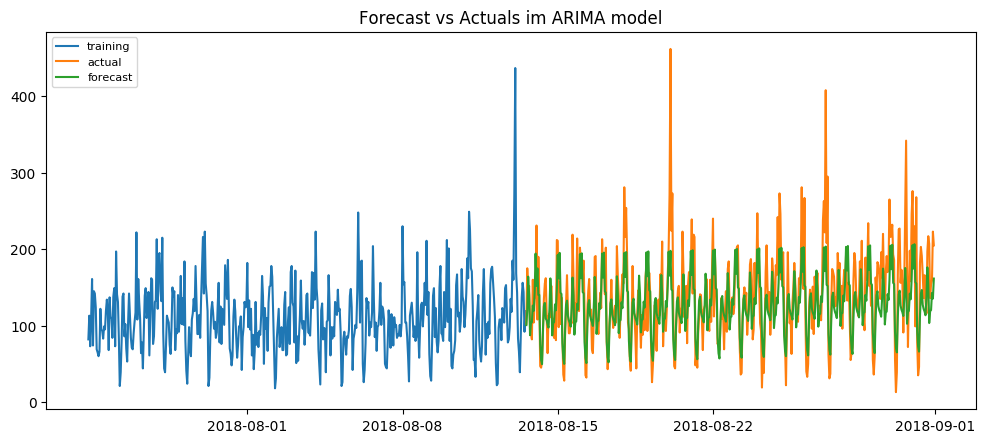

In [24]:
# Build Model
model = ARIMA(train, order=(3,1,1), seasonal_order=(2,0,1,24))  
fit = model.fit()  

# Forecast
forecast = fit.forecast(443, alpha=0.05) 

# Make as pandas series
fc_series = pd.Series(forecast, index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train[3500:], label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.title('Forecast vs Actuals im ARIMA model')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [25]:
fc_series = pd.Series(forecast, index=test.index)

In [26]:
rmse_am = sqrt(mean_squared_error(test.num_orders, fc_series))
print('RMSE for forecast ARIMA model =', rmse_am)

RMSE for forecast ARIMA model = 41.77758370029496


**Model with prediction**

In [27]:
# Build Model with train set to predict the test set 
model_ar = ARIMA(train, order=(3,1,1), seasonal_order=(2,0,1,24)) 
model_ar = model_ar.fit() 
pred_test = model_ar.predict(start=test.index[0], end=test.index[-1], type='levels')

In [28]:
rmse_am = sqrt(mean_squared_error(test.num_orders, pred_test))
print('RMSE for predict ARIMA model =', rmse_am)

RMSE for predict ARIMA model = 41.77758370029496


In [29]:
# Build Model with df set to forcast the next hour
model_arf = ARIMA(df, order=(2,0,1), seasonal_order=(1,0,1,24)) 
model_arf = model_arf.fit() 
pred_test = model_arf.predict(start=test.index[0], end=test.index[-1], type='levels')
forecast = model_arf.forecast(2, alpha=0.05)

In [30]:
forecast

2018-09-01 00:00:00    245.189925
2018-09-01 01:00:00    200.232340
Freq: H, Name: predicted_mean, dtype: float64

In [31]:
rmse_am = sqrt(mean_squared_error(test.num_orders, pred_test))
print('RMSE for predict ARIMA model =', rmse_am)

RMSE for predict ARIMA model = 38.856335725982646


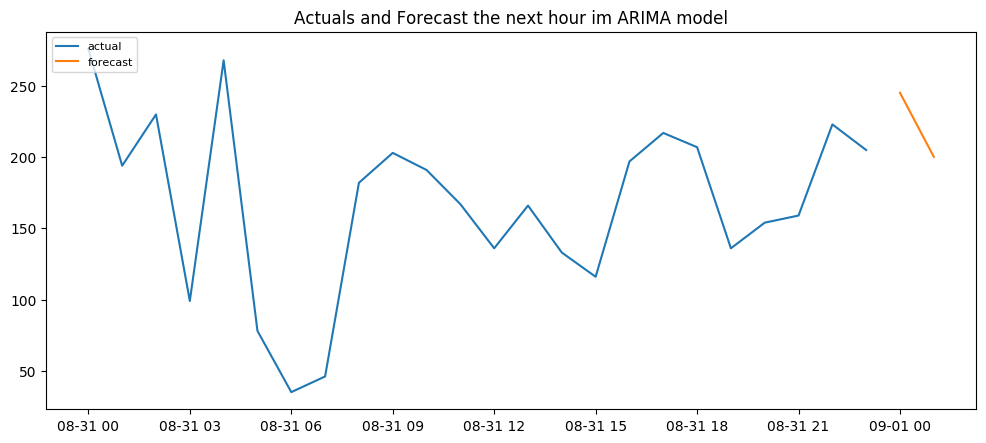

In [32]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df['2018-08-31'], label='actual')
plt.plot(forecast, label='forecast')
plt.title('Actuals and Forecast the next hour im ARIMA model')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [33]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
       
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

### LinearRegression with creating features

In [34]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)

In [35]:
train1 = train.copy()
for i in range(2, 75, 4):
    make_features(train1, i, i)
    train1.dropna(inplace=True)
    X_train = train1.drop('num_orders', axis=1)
    y_train = train1['num_orders']
    
    model = LinearRegression().fit(X_train, y_train)
    cv_score = cross_validate(model, X_train, y_train, cv=TimeSeriesSplit(), scoring="neg_root_mean_squared_error")
    mean_cv = abs(cv_score['test_score'].mean())
    print('i =', i, '| RMSE for LinearRegression model =', mean_cv)

i = 2 | RMSE for LinearRegression model = 31.536670551190838
i = 6 | RMSE for LinearRegression model = 31.53457364610562
i = 10 | RMSE for LinearRegression model = 31.531047573229944
i = 14 | RMSE for LinearRegression model = 31.267952317802393
i = 18 | RMSE for LinearRegression model = 31.092836549080765
i = 22 | RMSE for LinearRegression model = 30.270900408958937
i = 26 | RMSE for LinearRegression model = 26.781610450262427
i = 30 | RMSE for LinearRegression model = 26.43512061507828
i = 34 | RMSE for LinearRegression model = 26.551894790253062
i = 38 | RMSE for LinearRegression model = 26.69837791862907
i = 42 | RMSE for LinearRegression model = 27.01485454379958
i = 46 | RMSE for LinearRegression model = 26.67024034894468
i = 50 | RMSE for LinearRegression model = 24.91149421998408
i = 54 | RMSE for LinearRegression model = 24.98202591358181
i = 58 | RMSE for LinearRegression model = 25.044062898236785
i = 62 | RMSE for LinearRegression model = 25.189208348887007
i = 66 | RMSE for

The best RMSE was obtained when i = 50, now we test the data with i=50

In [36]:
train2 = train.copy()
make_features(train2, 50, 50)
train2.dropna(inplace=True)
X_train = train2.drop('num_orders', axis=1)
y_train = train2['num_orders']

test1 = test.copy()
make_features(test1, 50, 50)
test1.dropna(inplace=True)
X_test = test1.drop('num_orders', axis=1)
y_test = test1['num_orders']

model = LinearRegression().fit(X_train, y_train)
test_pred = model.predict(X_test)

rmse_lr = sqrt(mean_squared_error(test[-test_pred.shape[0]:], test_pred))
print('RMSE of LinearRegression model for test set =', rmse_lr)

RMSE of LinearRegression model for test set = 43.46182834908472


In [40]:
# Forecast the next hour with shift of the last value in the test set

# Select the last 50 values from test set (since the lag=50)
f = test[-50:]

# Replicate the last value
f1 = f.append(f[-1:])

# Set the index for the new data set
idx = pd.date_range('2018-08-29 21:00:00', periods=51, freq="H")
f1.set_index(idx, inplace=True)

# Make features
make_features(f1, 50, 50)
f1.drop('num_orders', axis=1, inplace=True)

# Forcast the last value (the next hour)
f1_forcast = model.predict(f1[-1:])

In [41]:
idx = pd.date_range('2018-09-01 00:00:00', periods=1, freq="H")
fc_series = pd.Series(f1_forcast, index=idx)
fc_series

2018-09-01    215.569352
Freq: H, dtype: float64

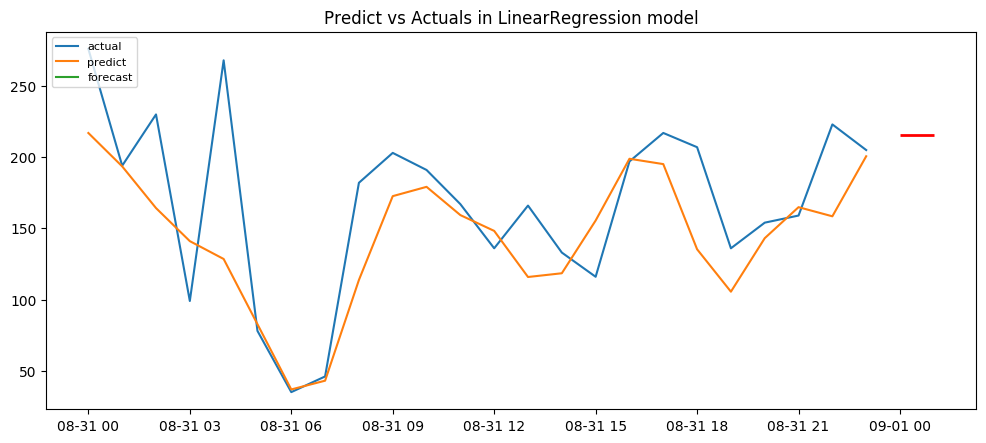

In [42]:
pred = pd.Series(test_pred, index=test[-test_pred.shape[0]:].index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(test['2018-08-31'], label='actual')
plt.plot(pred['2018-08-31'], label='predict')
plt.plot(fc_series, label='forecast', markersize=80)
plt.title('Predict vs Actuals in LinearRegression model')
plt.hlines(y=fc_series, xmin=fc_series.index, xmax='2018-09-01 01:00:00', linewidth=2, color='r')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Conclusion

In this project done for Sweet Lift Taxi company the goal is to attract drivers during peak hours so it is necessary to predict the number of future orders. For this purpose, data of several orders were received every 10 minutes from the last six months. We divided the data into one hour intervals and summed the groups between the intervals. According to the information, it could be seen that the data is not so stationary (mostly yes, but towards the summer it has an upward trend that generally makes it non-stationary).

Two models and a sanity model were tested. Indeed in general there is a difference in rmse between sanity model and the other two models which indicates that these models will be better than sanity model. 

In the ARIMA model auto_arima was done to test the best values of hyperparamters, using these hyperparameters we build the model to forcast the next hour. The result obtained 245 orders for the next hour and the rmse obtained was 41. In contrast, in the linear regression model with make features, the best value obtained was for lag = 50 and using it we made a prediction for the test set when the rmse obtained was 43 with a forecast of 215 orders. 

It can be assumed that since the ARUMA model is more accurate, then its forecast is also more accurate and in any case it is also larger, so potentially it can attract more drivers to enlist in the company.